In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet

df = pd.read_csv('DSA_jobs_JobDate.csv', sep=',', header=0, parse_dates=[0], dayfirst=True)
df.head()

ds    y
0 2012-01-01  321
1 2012-01-02  143
2 2012-01-03  132
3 2012-01-04  411
4 2012-01-05  836

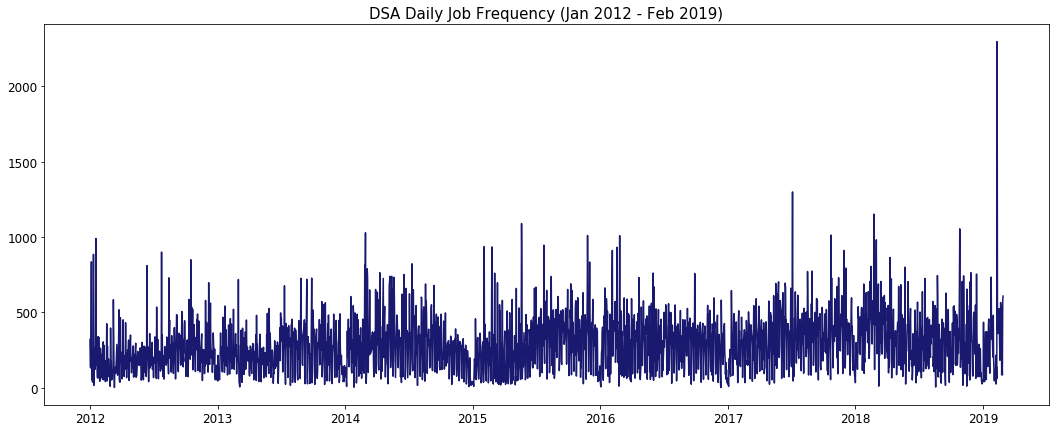

In [3]:
#plot DSA jobs

plt.rcParams["figure.figsize"] = [18, 7]
plt.rcParams.update({'font.size': 12})
plt.plot(df['ds'], df['y'], color='midnightblue');
plt.title('DSA Daily Job Frequency (Jan 2012 - Feb 2019)', fontsize=15);
plt.savefig('dsadailyjobs.png', bbox_inches='tight')

### Model Forecasting

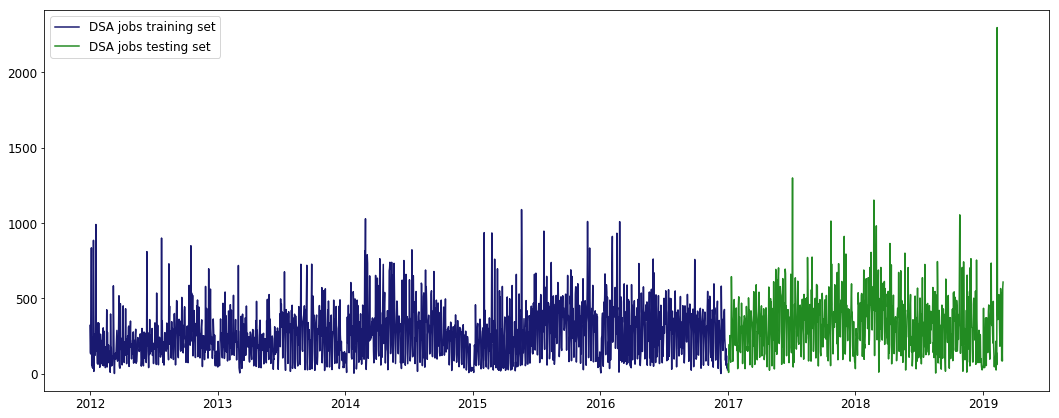

In [5]:
# create train and test segments

X_train = df[df['ds'] < '2017-01-01'] #70% of dataset
X_test = df[df['ds'] >= '2017-01-01'] #30% of dataset

plt.plot(X_train['ds'], X_train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(X_test['ds'], X_test['y'], 'forestgreen', label='DSA jobs testing set');
plt.legend(loc='upper left');
plt.savefig('trainandtest.png', bbox_inches='tight')

[5.90793514e-02 2.13765406e+02]


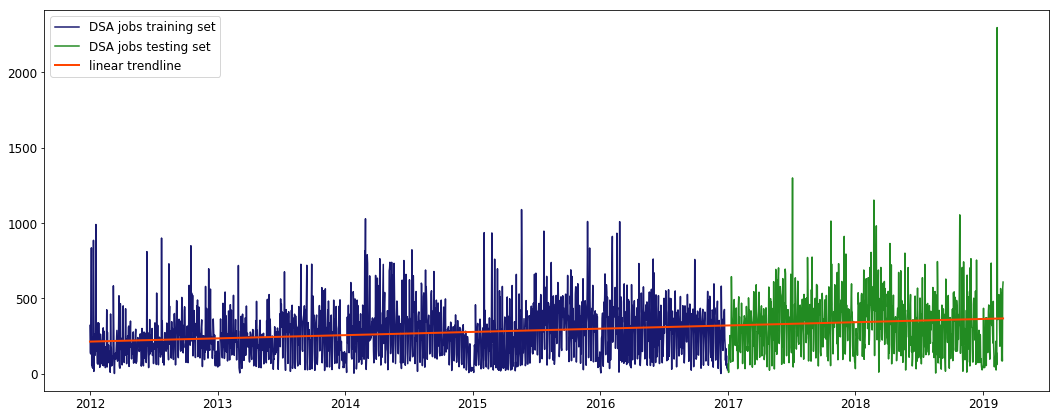

In [7]:
# fit a linear trendline to set baseline for model performance
import numpy as np

tl_coef = np.polyfit(X_train.index, X_train['y'], 1)
print(tl_coef)

tl = np.poly1d(tl_coef)

df['tl_ypred'] = tl(df.index)

# plot on orders chart

plt.plot(X_train['ds'], X_train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(X_test['ds'], X_test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(df['ds'], df['tl_ypred'], 'orangered', label='linear trendline', linewidth=2);
plt.legend(loc='best');
plt.savefig('andnowwithtrend.png', bbox_inches='tight')

In [8]:
# look at RMSE of trendline to data

training_pred = df['tl_ypred'].where(df['ds'] < '2017-1-01')
testing_pred = df['tl_ypred'].where(df['ds'] >= '2017-01-01')

# Calculate root mean squared error.

print('Training Set RMSE: %2f' % np.sqrt(np.mean((training_pred - X_train['y']) ** 2)))
print('Testing Set RMSE: %2f' % np.sqrt(np.mean((testing_pred - X_test['y']) ** 2)))

Training Set RMSE: 167.444329
Testing Set RMSE: 197.499830


[-3.82143469e-05  1.28361962e-01  1.92842057e+02]


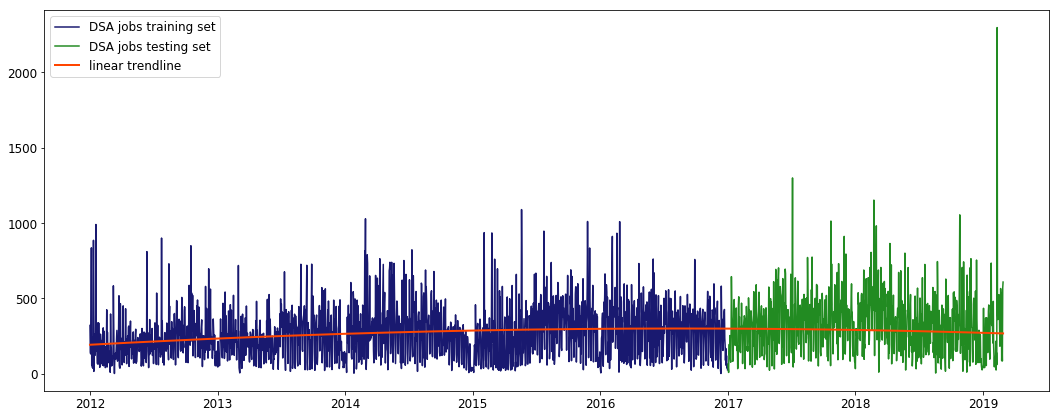

In [9]:
# fit a linear trendline to set baseline for model performance

# 2nd degree polynomial

tl_coef = np.polyfit(X_train.index, X_train['y'], 2)
print(tl_coef)
tl = np.poly1d(tl_coef)

df['tl_ypred'] = tl(df.index)

# plot on orders chart

plt.plot(X_train['ds'], X_train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(X_test['ds'], X_test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(df['ds'], df['tl_ypred'], 'orangered', label='linear trendline', linewidth=2);
plt.legend(loc='best');

In [10]:
# look at RMSE of trendline to data

training_pred = df['tl_ypred'].where(df['ds'] < '2017-01-01')
testing_pred = df['tl_ypred'].where(df['ds'] >= '2017-01-01')

# Calculate root mean squared error.

print('Training Set RMSE: %2f' % np.sqrt(np.mean((training_pred - X_train['y']) ** 2)))
print('Testing Set RMSE: %2f' % np.sqrt(np.mean((testing_pred - X_test['y']) ** 2)))

Training Set RMSE: 167.181805
Testing Set RMSE: 200.412487


RSME was slightly worse on testing data

### Predicting future DSA jobs with Facebook's Prophet

In [12]:
# dataframe input should be 2 columns with 'ds' and 'y' names

train = df[df['ds'] < '2017-01-01'] #70% of dataset
test = df[df['ds'] >= '2017-01-01'] #30% of dataset

In [13]:
#mute unimportant diagnostic messages
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)

In [14]:
# fit model with standard parameters

m = Prophet()
m.fit(train)

# get number of days to match prediction to testing data

test_days = (test['ds'].max() - train['ds'].max()).days

# create forecast

future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)
forecast.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2012-01-01  203.314707 -259.069761   99.724549   203.314707   203.314707   
1 2012-01-02  203.398746 -181.389808  169.567877   203.398746   203.398746   
2 2012-01-03  203.482784  -57.407080  301.963984   203.482784   203.482784   
3 2012-01-04  203.566823  -20.513946  329.416788   203.566823   203.566823   
4 2012-01-05  203.650861    8.813703  361.091972   203.650861   203.650861   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -282.985427           -282.985427           -282.985427 -154.703369   
1     -213.915331           -213.915331           -213.915331  -91.809965   
2      -80.055862            -80.055862            -80.055862   34.768882   
3      -54.019657            -54.019657            -54.019657   52.551229   
4      -15.862982            -15.862982            -15.862982   81.628435   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0   -154.703369   -154.703369 -128.282058   -128.282058   -128.282058   
1    -91.809965    -91.809965 -122.105365   -122.105365   -122.105365   
2     34.768882     34.768882 -114.824744   -114.824744   -114.824744   
3     52.551229     52.551229 -106.570886   -106.570886   -106.570886   
4     81.628435     81.628435  -97.491418    -97.491418    -97.491418   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  -79.670720  
1                         0.0  -10.516585  
2                         0.0  123.426922  
3                         0.0  149.547165  
4                         0.0  187.787879

In [15]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2598 2019-02-24  275.114751  -34.070933  314.248327   254.056460   296.462860   
2599 2019-02-25  275.087298   32.760454  381.784994   253.967805   296.453586   
2600 2019-02-26  275.059845  151.849756  511.924378   253.879150   296.443560   
2601 2019-02-27  275.032392  171.796886  523.876065   253.790495   296.433534   
2602 2019-02-28  275.004939  198.294666  562.374282   253.712824   296.423509   

      additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
2598     -129.490576           -129.490576           -129.490576 -154.703369   
2599      -65.382189            -65.382189            -65.382189  -91.809965   
2600       61.757914             61.757914             61.757914   34.768882   
2601       79.422495             79.422495             79.422495   52.551229   
2602      107.694629            107.694629            107.694629   81.628435   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
2598   -154.703369   -154.703369  25.212793     25.212793     25.212793   
2599    -91.809965    -91.809965  26.427777     26.427777     26.427777   
2600     34.768882     34.768882  26.989032     26.989032     26.989032   
2601     52.551229     52.551229  26.871266     26.871266     26.871266   
2602     81.628435     81.628435  26.066193     26.066193     26.066193   

      multiplicative_terms  multiplicative_terms_lower  \
2598                   0.0                         0.0   
2599                   0.0                         0.0   
2600                   0.0                         0.0   
2601                   0.0                         0.0   
2602                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
2598                         0.0  145.624175  
2599                         0.0  209.705110  
2600                         0.0  336.817759  
2601                         0.0  354.454887  
2602                         0.0  382.699568

Training Set RMSE: 137.701051
Testing Set RMSE: 182.061121


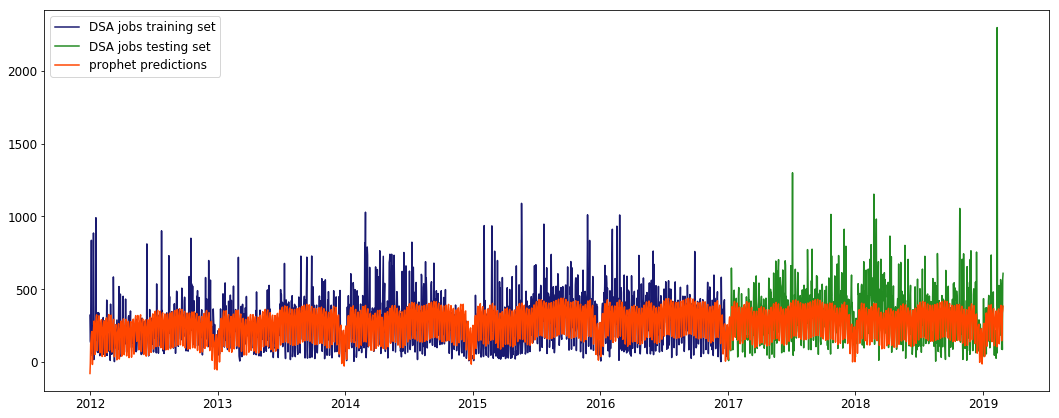

In [16]:
# plot forecast results and check RMSE

plt.plot(train['ds'], train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(test['ds'], test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prophet predictions');
plt.legend(loc='best');
plt.savefig('firstprophetpred.png', bbox_inches='tight')

# split forecast into train/test segments

fc_train = forecast[forecast['ds'] < '2017-01-01']
fc_test = forecast[forecast['ds'] >= '2017-01-01']

from sklearn.metrics import mean_squared_error

print('Training Set RMSE: %2f' % np.sqrt(mean_squared_error(train['y'], fc_train['yhat'])))
print('Testing Set RMSE: %2f' % np.sqrt(mean_squared_error(test['y'], fc_test['yhat'])))

Training Set RMSE: 137.701051
Testing Set RMSE: 182.061121


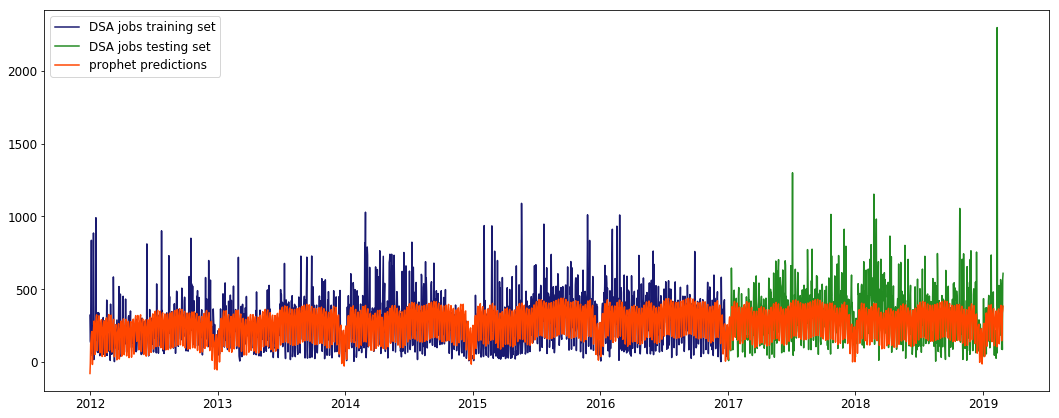

In [17]:
# switching yearly seasonality to true

m = Prophet(yearly_seasonality=True)
m.fit(train)

# create forecast

future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)

# plot new forecast and look at errors

plt.plot(train['ds'], train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(test['ds'], test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prophet predictions');
plt.legend(loc='best');
plt.savefig('prophetwseasonality.png', bbox_inches='tight')

fc_train = forecast[forecast['ds'] < '2017-01-01']
fc_test = forecast[forecast['ds'] >= '2017-01-01']

print('Training Set RMSE: %2f' % np.sqrt(mean_squared_error(train['y'], fc_train['yhat'])))
print('Testing Set RMSE: %2f' % np.sqrt(mean_squared_error(test['y'], fc_test['yhat'])))

Training Set RMSE: 137.701051
Testing Set RMSE: 182.061121


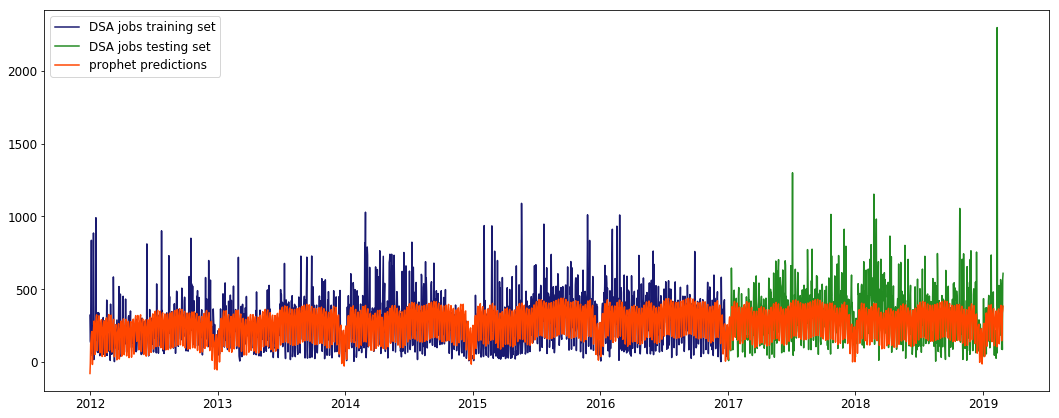

In [18]:
# switching weekly seasonality to true
# set daily seasonality to false to remove warning

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train)

# create forecast

future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)

# plot new forecast and look at errors

plt.plot(train['ds'], train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(test['ds'], test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prophet predictions');
plt.legend(loc='best');

fc_train = forecast[forecast['ds'] < '2017-01-01']
fc_test = forecast[forecast['ds'] >= '2017-01-01']

print('Training Set RMSE: %2f' % np.sqrt(mean_squared_error(train['y'], fc_train['yhat'])))
print('Testing Set RMSE: %2f' % np.sqrt(mean_squared_error(test['y'], fc_test['yhat'])))

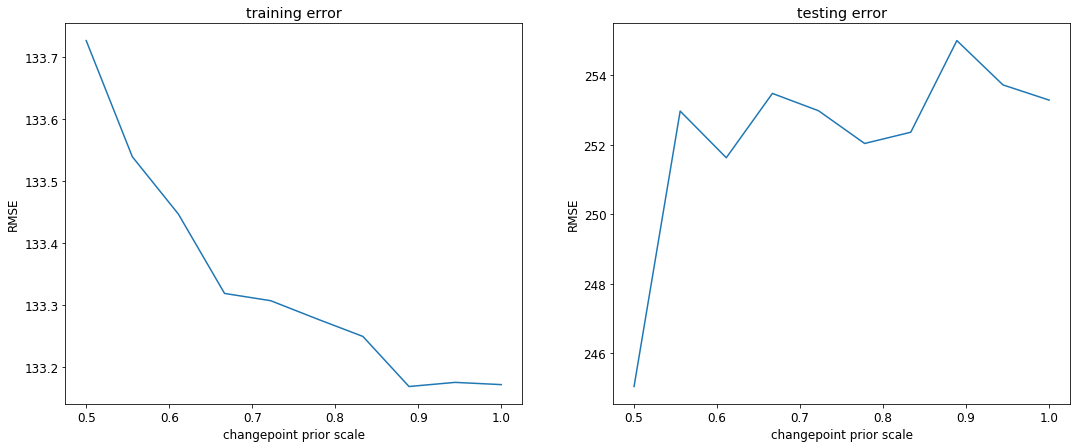

In [19]:
# find optimal value for changepoint_prior_scale (flexibility of model)

cps = [0.01, 0.1, 1, 10]
# cps2 = np.linspace(0.001, 3, 100)
cps2 = np.linspace(0.5, 1.0, 10)
train_rmse = []
test_rmse = []

for var in cps2:
    
    m = Prophet(yearly_seasonality=True, changepoint_prior_scale=var)
    m.fit(train)

    future = m.make_future_dataframe(periods=test_days)
    forecast = m.predict(future)
    
    fc_train = forecast[forecast['ds'] < '2017-01-01']
    fc_test = forecast[forecast['ds'] >= '2017-01-01']

    error_train = np.sqrt(mean_squared_error(train['y'], fc_train['yhat']))
    error_test = np.sqrt(mean_squared_error(test['y'], fc_test['yhat']))
    
    train_rmse.append(error_train)
    test_rmse.append(error_test)
    
plt.subplot(121, title='training error', ylabel='RMSE', xlabel='changepoint prior scale')
plt.plot(cps2, train_rmse);
plt.subplot(122, title='testing error', ylabel='RMSE', xlabel='changepoint prior scale')
plt.plot(cps2, test_rmse);

Training Set RMSE: 137.701051
Testing Set RMSE: 182.061121


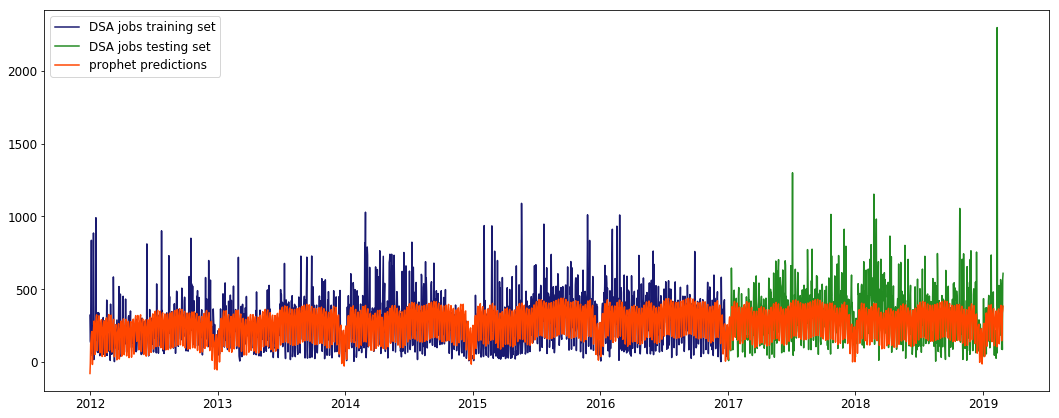

In [25]:
m = Prophet(yearly_seasonality=True)
m.fit(train)

future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)

# plot new forecast

plt.plot(train['ds'], train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(test['ds'], test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prophet predictions');
plt.legend(loc='best');

fc_train = forecast[forecast['ds'] < '2017-01-01']
fc_test = forecast[forecast['ds'] >= '2017-01-01']

print('Training Set RMSE: %2f' % np.sqrt(mean_squared_error(train['y'], fc_train['yhat'])))
print('Testing Set RMSE: %2f' % np.sqrt(mean_squared_error(test['y'], fc_test['yhat'])))

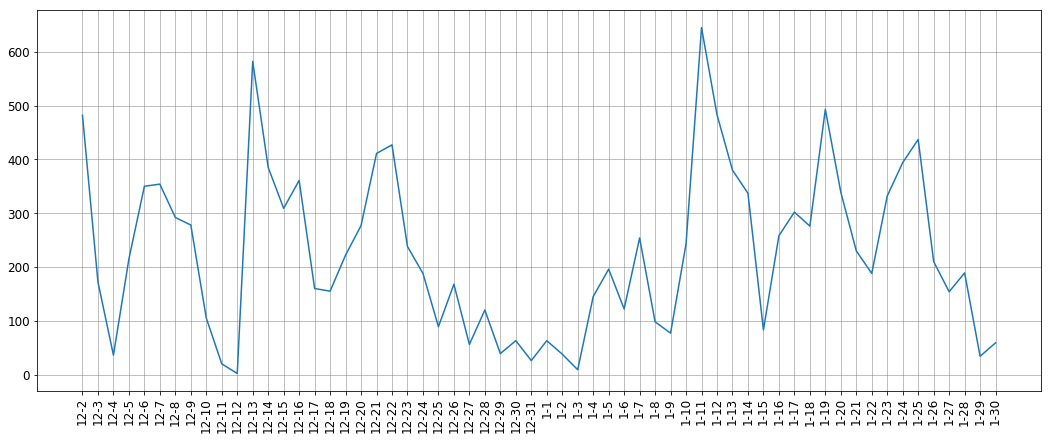

In [32]:
# View holiday period

#2016
christmas16 = df[(df['ds'] > '2016-12-01') & (df['ds'] < '2017-01-31')]
plt.plot(christmas16.index, christmas16['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in christmas16['ds']]
plt.xticks(christmas16.index, ticks, rotation='vertical');

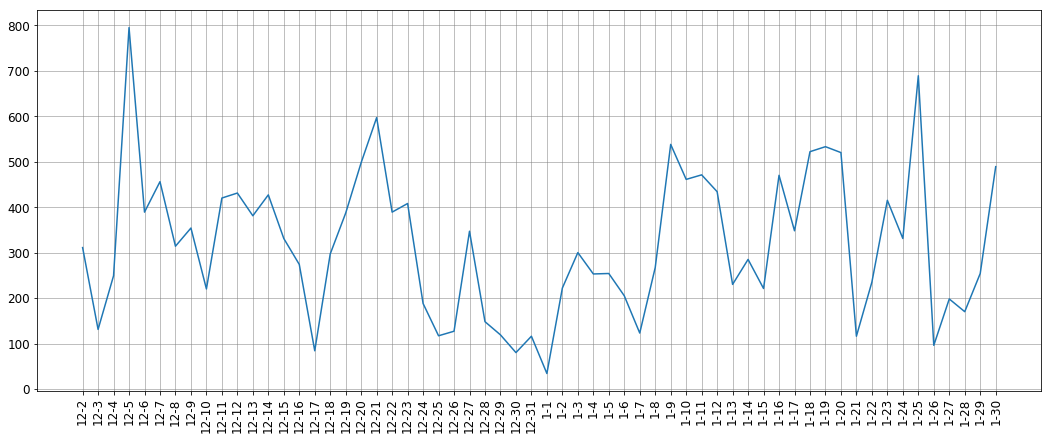

In [33]:
#2017
christmas17 = df[(df['ds'] > '2017-12-01') & (df['ds'] < '2018-01-31')]
plt.plot(christmas17.index, christmas17['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in christmas17['ds']]
plt.xticks(christmas17.index, ticks, rotation='vertical');

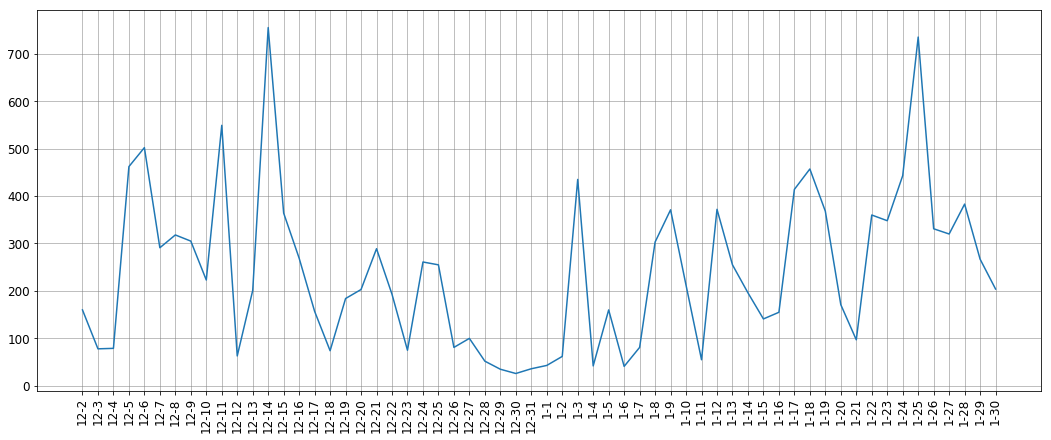

In [30]:
#2018
christmas18 = df[(df['ds'] > '2018-12-01') & (df['ds'] < '2019-01-31')]
plt.plot(christmas18.index, christmas18['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in christmas18['ds']]
plt.xticks(christmas18.index, ticks, rotation='vertical');

There definitely seems to be a drop-off of posting frequency between Christmas and New Years Day.

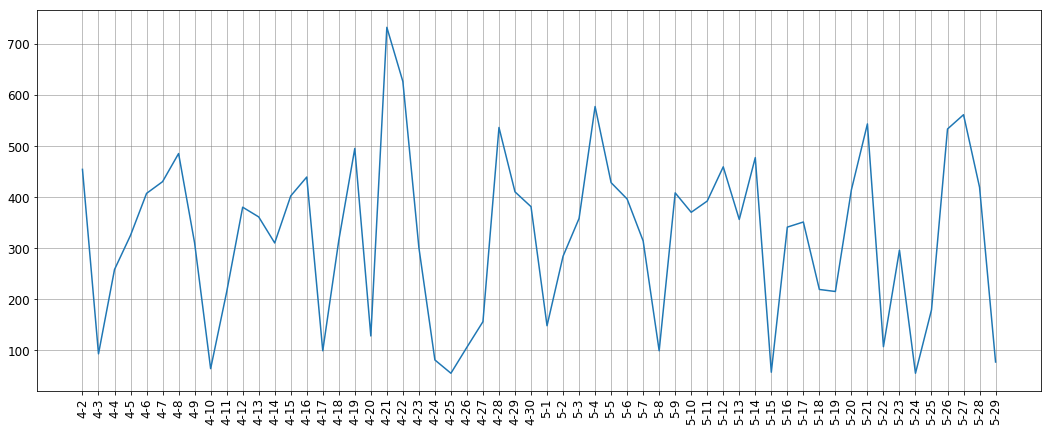

In [37]:
# look at the Easter period
# 2016 Good Friday occurred on 25/4 (same as ANZAC day)

easter16 = df[(df['ds'] > '2016-04-01') & (df['ds'] < '2016-05-30')]
plt.plot(easter16.index, easter16['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in easter16['ds']]
plt.xticks(easter16.index, ticks, rotation='vertical');

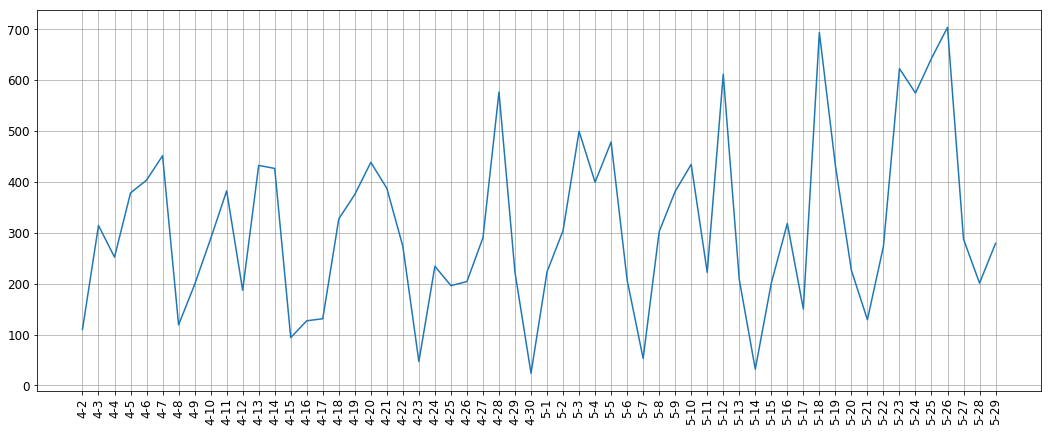

In [39]:
# 2017 Good Friday occurred on 14/4
# ANZAC day 25/4

easter17 = df[(df['ds'] > '2017-04-01') & (df['ds'] < '2017-05-30')]
plt.plot(easter17.index, easter17['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in easter17['ds']]
plt.xticks(easter17.index, ticks, rotation='vertical');

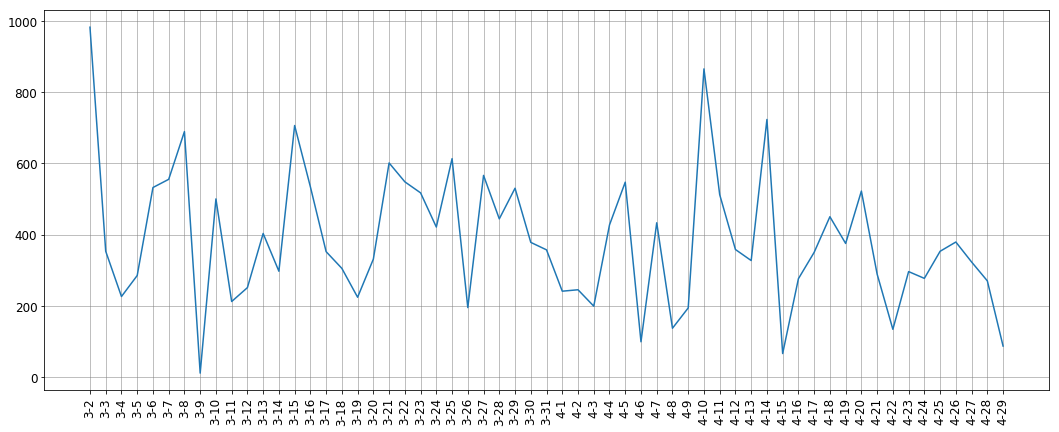

In [42]:
# 2018 Good Friday occurred on 30/3
# ANZAC day 25/4

easter18 = df[(df['ds'] > '2018-03-01') & (df['ds'] < '2018-04-30')]
plt.plot(easter18.index, easter18['y']);
plt.grid(color='gray', linestyle='-', linewidth=0.5);
ticks = [str(x.month) + '-' + str(x.day) for x in easter18['ds']]
plt.xticks(easter18.index, ticks, rotation='vertical');

While it's difficult to say whether the Easter period has an effect, the Christmas period certainly experiences a departure from the trend. So, I'll experiment with removing the Christmas - NYD week from the forecast to see if performance improves.

In [43]:
# create custom holidays DataFrame

christmas = pd.DataFrame({'holiday': 'Christmas Day',
                          'ds': pd.to_datetime(['2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25',
                                                '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25']),
                          'lower_window': 0,
                          'upper_window': 0})

boxing_day = pd.DataFrame({'holiday': 'Boxing Day',
                          'ds': pd.to_datetime(['2012-12-26', '2013-12-26', '2014-12-26', '2015-12-26',
                                                '2016-12-26', '2017-12-26', '2018-12-26', '2019-12-26']),
                          'lower_window': 0,
                          'upper_window': 6})
# upper_window of 6 days to mark this period (including NYD) as a holiday
holidays = pd.concat((christmas, boxing_day))

Training Set RMSE: 136.731275
Testing Set RMSE: 182.167156


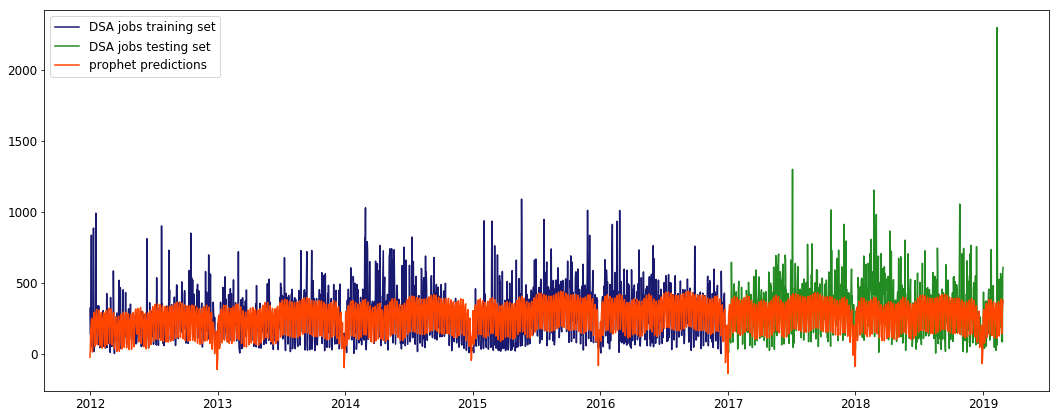

In [45]:
# use custom holidays input

m = Prophet(yearly_seasonality=True,
            holidays=holidays)
m.fit(train)

future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)

plt.plot(train['ds'], train['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(test['ds'], test['y'], 'forestgreen', label='DSA jobs testing set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prophet predictions');
plt.legend(loc='best');

fc_train = forecast[forecast['ds'] < '2017-01-01']
fc_test = forecast[forecast['ds'] >= '2017-01-01']

print('Training Set RMSE: %2f' % np.sqrt(mean_squared_error(train['y'], fc_train['yhat'])))
print('Testing Set RMSE: %2f' % np.sqrt(mean_squared_error(test['y'], fc_test['yhat'])))

Holidays make almost no difference (Training RSME slightly better and Testing RSME slightly worse).

Forecast RMSE: 149.434741


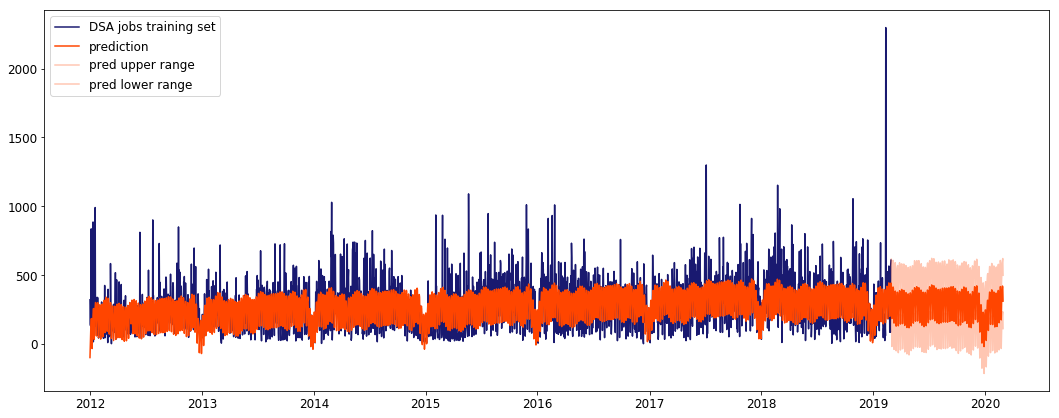

In [47]:
# train on whole data set and build prediction for 12 months from 1/3/19 - 29/2/2020

m = Prophet(yearly_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

pred_range_df = forecast[forecast['ds'] >= '2019-03-01']

plt.plot(df['ds'], df['y'], 'midnightblue', label='DSA jobs training set');
plt.plot(forecast['ds'], forecast['yhat'], 'orangered', label='prediction');
plt.plot(pred_range_df['ds'], pred_range_df['yhat_upper'], 'orangered', label='pred upper range', alpha=0.3);
plt.plot(pred_range_df['ds'], pred_range_df['yhat_lower'], 'orangered', label='pred lower range', alpha=0.3);
#plt.grid(color='gray', linestyle='-', linewidth=0.5);
plt.legend(loc='best');
plt.savefig('prediction.png', bbox_inches='tight')

error_test_df = forecast[forecast['ds'] < '2019-03-01']

print('Forecast RMSE: %2f' % np.sqrt(mean_squared_error(df['y'], error_test_df['yhat'])))

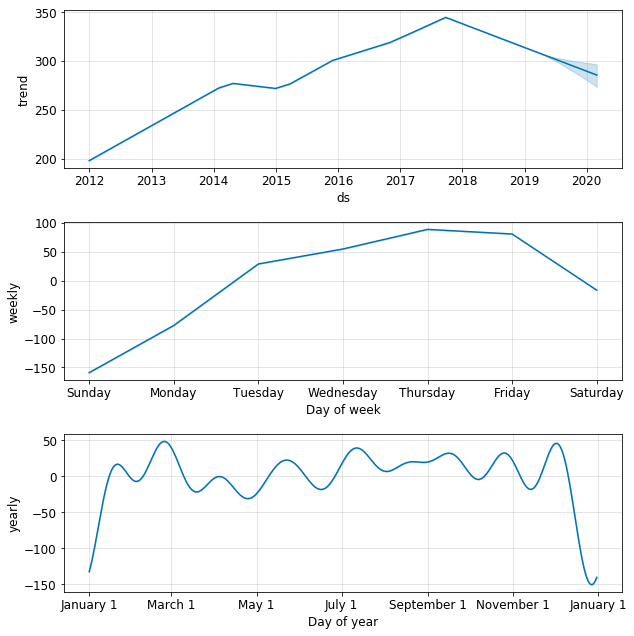

In [48]:
plot = m.plot_components(forecast)

In [49]:
#Create a plotly time series plot
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig1 = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig1)

### Cross Validation with Prophet

In [50]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1814 days', horizon = '366 days')
df_cv.head()

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 2017-02-27  218.991377   52.501877  409.088135  150 2017-02-26
1 2017-02-28  344.210198  176.399298  522.428192  243 2017-02-26
2 2017-03-01  361.626875  191.271734  527.192456  504 2017-02-26
3 2017-03-02  387.307440  210.754682  554.012641  410 2017-02-26
4 2017-03-03  393.129475  225.265046  571.576303  426 2017-02-26

In [51]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper    y     cutoff
1093 2019-02-24  289.336034  113.013906  466.411916   87 2018-02-27
1094 2019-02-25  371.812453  199.704271  540.485411  202 2018-02-27
1095 2019-02-26  491.687221  309.699781  666.746253   85 2018-02-27
1096 2019-02-27  512.214864  331.499572  689.895614  571 2018-02-27
1097 2019-02-28  539.177352  349.214396  714.219912  609 2018-02-27

### Obtaining performance metrics

In [52]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse        rmse        mae      mape  coverage
0 37 days  18175.144212  134.815222  98.737240  0.682802  0.853211
1 38 days  18034.519533  134.292664  97.682233  0.707752  0.856269
2 39 days  15839.662230  125.855720  92.910459  0.702179  0.868502
3 40 days  15120.013421  122.963464  92.120951  0.706548  0.871560
4 41 days  15480.307589  124.419884  94.464834  0.723098  0.871560

In [53]:
df_p.tail()

horizon           mse        rmse         mae      mape  coverage
325 362 days  78504.078719  280.185793  181.778752  1.280752  0.550459
326 363 days  78939.571427  280.961868  183.792252  1.302900  0.550459
327 364 days  79772.699273  282.440612  184.693855  1.332853  0.553517
328 365 days  79800.503054  282.489828  184.453516  1.323438  0.556575
329 366 days  79669.390052  282.257666  183.744138  1.311366  0.556575

### Visualising performance metrics

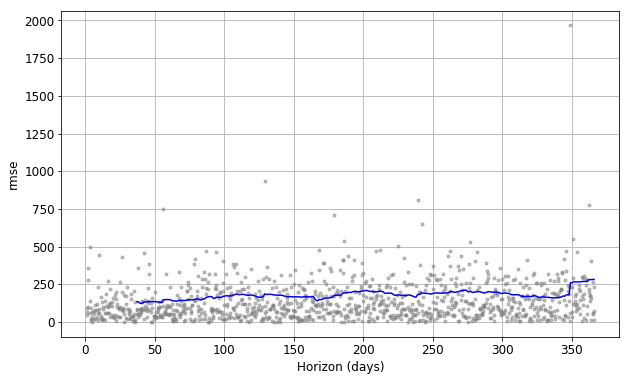

In [54]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

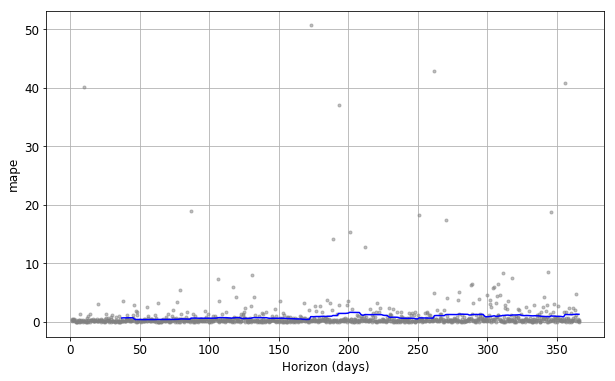

In [55]:
fig2 = plot_cross_validation_metric(df_cv, metric='mape')